<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [76]:
%%capture
pip install pyswarms

In [77]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [78]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [79]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [80]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [81]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [82]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [83]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [84]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [85]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [86]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [87]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [88]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


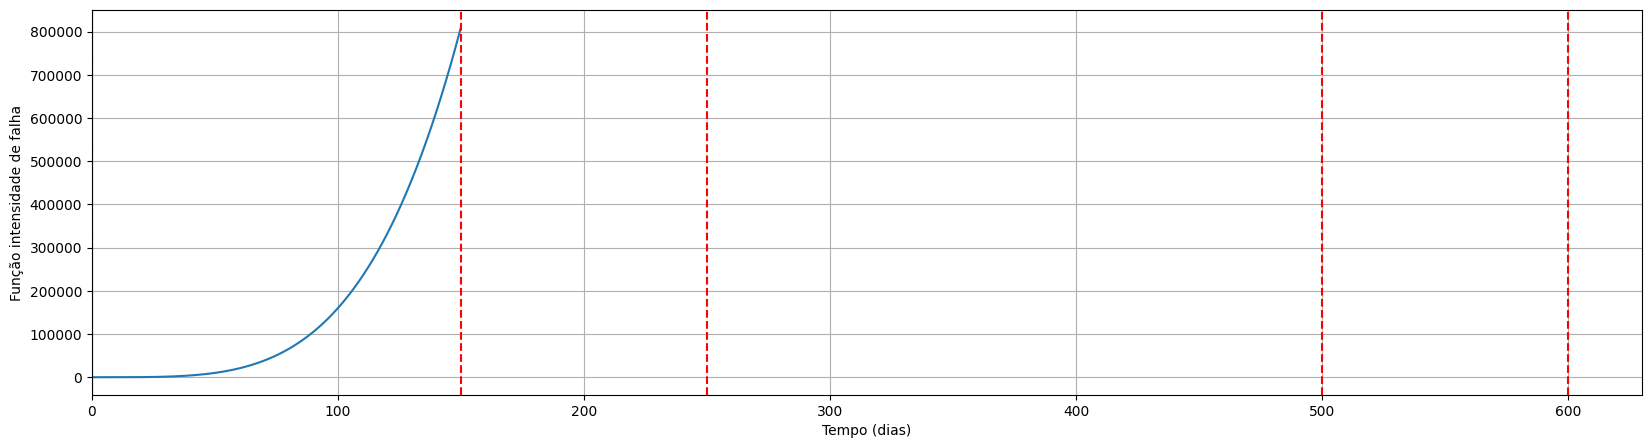

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [89]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [90]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [91]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-01 02:59:38,585 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  11%|█         |11/100, best_cost=5.69e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 29, 43, 118, 254, 283, 301, 381, 403, 422, 626, 666]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 6563.56768, 19054.62427528631, 1995840.020977281, 61427815.83068735, 67954531.67027843, 98777746.59046699, 433215086.9839946, 451788499.83222955, 578540991.0712826, 6814659249.541995, 8456137855.005824, 8571947018.136788]
Custo =  350054091580.62933


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 35, 68, 119, 153, 187, 272, 311, 330, 559, 579, 650, 670]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.

pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=4.51e+10

Media de falhas:  [0, 228775.77568000002, 253962.31144169217, 651960.7370531741, 1490739.6929828343, 39678484.57493746, 125056650.02798297, 146840213.26836854, 179796536.641222, 198943369.4152868, 283039222.0285217, 406274006.7810254, 1298071850.1838326, 1731023157.2650285, 1988542323.8442814, 4766083566.370543]
Custo =  415891702745.9973


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 61, 114, 205, 225, 266, 277, 328, 331, 400, 433, 451, 497, 566, 579]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 270270.81632000004, 2568418.1198460674, 941361

pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 59, 138, 197, 232, 250, 277, 312, 378, 440, 569, 580]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 127379.91971803563, 2255257.9903276125, 19876625.29855189, 20806070.521373253, 23129682.47569462, 24200910.45907871, 26633008.5471858, 82043365.00754651, 102156457.27581525, 732824646.0361631, 770357193.142745, 1303747924.375504]
Custo =  54458188836.60047


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 57, 139, 188, 230, 249, 275, 316, 376, 440, 554, 583]
Severidade para cada subsistema: [0.75, 0.25, 

pyswarms.single.global_best:  66%|██████▌   |66/100, best_cost=4.51e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 21, 55, 170, 203, 229, 253, 319, 376, 438, 579]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 83321.02401522476, 10769277.76841396, 21988414.720550217, 24555337.57491495, 27952767.602579616, 36579352.193201266, 47066708.448472045, 66890054.6638972, 837748103.6325136, 2742334223.5351286]
Custo =  77561259749.69049


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 21, 57, 124, 162, 209, 229, 254, 287, 318, 378, 439, 559, 579]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5

pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=4.51e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 17, 124, 207, 230, 252, 313, 375, 441, 560, 584]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 454.35424000000006, 7444710.09771377, 12751582.210292976, 13191660.072650716, 16211327.909122411, 23116165.893219102, 35330697.93281083, 58055135.564250186, 585074254.0734234, 672347497.8316977, 1175692617.9574568]
Custo =  49828513534.47397


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 19, 124, 205, 230, 252, 315, 375, 390, 440, 585]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607,

pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 57, 127, 189, 229, 255, 271, 314, 377, 393, 440, 584]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 118773.54300559624, 1357923.2714589874, 17112091.927492335, 18268242.41134877, 22121519.712709524, 22589461.51210323, 26125541.268756445, 77555400.15684174, 79426787.27162829, 141790992.39150688, 962901140.0489992, 2774073950.9469037]
Custo =  83723812851.8644


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 126, 193, 228, 255, 297, 317, 376, 390, 440, 583]
Severidade para cada subsistema: [0.75, 0.75

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.51e+10
2023-09-01 02:59:40,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788098 1.78865759 4.71282316 1.92115007 4.86408262 0.5739146
 5.07974814 5.60007899 5.52553785 5.48123325 5.68809594 3.14045534
 3.64909133 3.0578031  3.54169641 2.5795105  2.24147544 4.23981404
 5.16429872 3.56262506 4.21827893 2.38051959 2.60623027 4.11605362]
2023-09-01 02:59:40,030 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 57, 120, 150, 230, 249, 273, 314, 377, 390, 437, 582]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 118773.54300559624, 915115.4962067195, 3932388.478067486, 9938250.674474834, 10374563.3295856, 11225171.481967682, 14475070.254161693, 27283386.59697801, 28700514.89231181, 89473209.38684464, 910328792.2513686, 2758527490.0466337]
Custo =  80332504691.1557


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 59, 121, 208, 228, 251, 275, 314, 376, 393, 437, 582]
Severidade para cada subsistema: [0.75, 0.2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75466619 1.78795368 4.71355208 1.92114836 4.86444841 0.57387518
 5.07960188 5.60192648 5.52603777 3.24748964 5.6881363  3.1409068
 3.64922686 3.05783214 3.54179262 2.57905828 2.24151244 4.23943078
 3.16590841 3.56150298 4.21790079 2.38054589 2.60581351 4.11691604]
2023-09-01 02:59:40,044 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 57, 119, 156, 193, 231, 254, 316, 376, 439, 568, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 105016.02972121746, 850136.1438282988, 5187044.312910663, 15400003.430619271, 16472803.252328686, 19752134.01298254, 27097659.79420958, 38655856.43994858, 59214153.19589557, 686082112.4677821, 751296400.8612323, 2525889577.7582383]
Custo =  88089550519.07431


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 21, 55, 112, 198, 232, 255, 290, 317, 336, 377, 440, 588]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 83321.02401522476, 593670.6442084401, 27786573.65772948, 47594350.103786126, 50923284.56787641, 52829873.50897819, 54542626.926171914, 105151134.73748055, 111106098.14905241, 201487266.95000863, 1080097558.158278, 2818551965.887974]
Custo =  94382061684.17363


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75540896 1.78849461 4.71388898 1.9211461  4.86463015 0.57388991
 5.07957197 5.60206652 5.52445369 2.30660856 5.68813534 3.14132103
 3.64911855 3.05861617 3.54182526 2.58023438 2.24156913 4.2425099
 2.75774454 3.56132743 4.21828003 2.38054495 2.60579741 4.11671546]
2023-09-01 02:59:40,058 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75611596 1.78900897 4.71394781 1.92114475 4.86474424 0.57390424
 5.07957492 5.60171565 5.52303226 1.14024457 5.68813128 3.14157024
 3.64901523 3.05910376 3.54184755 2.58118208 2.24161243 4.2449932
 2.31451027 3.5612



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 106, 205, 232, 256, 282, 318, 342, 379, 440, 589]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 431814.80369393993, 37231927.90382148, 53125818.72655256, 56679358.80561473, 57754491.824629046, 60470162.389995314, 71283428.70826423, 76432594.24896577, 163067982.6549719, 1056524775.6033945, 2777073448.277643]
Custo =  85772311858.01263


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7567638  1.78946461 4.71374722 1.92114435 4.86466593 0.57391967
 5.0795997  5.60098789 5.52181315 6.62924119 5.68812201 3.14177936
 3.64893678 3.05922811 3.54186375 2.5815639  2.24163667 4.24612468
 1.89053025 3.56153309 4.21891675 2.38052816 2.60589212 4.11617741]
2023-09-01 02:59:40,086 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 23, 51, 102, 232, 257, 320, 347, 381, 440, 590]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 51151.34013811694, 353338.8312758554, 83266814.51986916, 105603228.20888616, 113482360.95115586, 115840800.80458565, 120446889.33244306, 203409466.0834059, 1111905028.2788832, 2814656176.4591317]
Custo =  86048800385.36737


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,101 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75742842 1.78975201 4.71345052 1.92114452 4.86454525 0.57393248
 5.07966295 5.60006701 5.52156482 4.44524852 5.68811124 3.14188487
 3.64890852 3.05903199 3.54185096 2.58151049 2.24164037 4.24558316
 1.53209963 3.5620753  4.2190305  2.38051758 2.60604588 4.11592402]
2023-09-01 02:59:40,103 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 24, 49, 101, 231, 257, 273, 321, 350, 381, 440, 590]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 39675.308874226925, 355529.3620327989, 81976111.97105603, 105166768.75758502, 105647521.11553255, 110283462.4470094, 112981477.21374197, 116997124.46774842, 199959701.21871126, 1108455263.4141884, 2811206411.5944366]
Custo =  86007827097.25519


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,116 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75812625 1.78975718 4.7131716  1.92114597 4.86441258 0.57394366
 5.0797335  5.59924092 5.52147064 1.8205576  5.68810111 3.14196493
 3.64893721 3.05851321 3.5417933  2.58108583 2.24163487 4.24441338
 1.20590228 3.56265277 4.21912142 2.3805086  2.60621019 4.11572596]
2023-09-01 02:59:40,118 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 25, 49, 103, 171, 187, 230, 258, 322, 351, 382, 439, 590]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 38694.77209664501, 408038.87891396845, 12202475.735145979, 16231006.441048577, 21325647.069928735, 22216490.870320074, 30510646.839932133, 33235971.24688094, 37289041.71118258, 115981399.32621981, 1034485538.6504036, 2737236686.830652]
Custo =  82256703743.67099


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,129 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75872686 1.78954561 4.71284146 1.92114802 4.86423496 0.57394588
 5.07979911 5.59859167 5.52193621 5.81314012 5.6880913  3.14178237
 3.64896775 3.05795589 3.54172984 2.58029276 2.24158277 4.24203338
 1.21277673 3.56317083 4.21896786 2.38050245 2.60636254 4.11556325]
2023-09-01 02:59:40,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 25, 49, 107, 161, 198, 228, 258, 323, 352, 382, 437, 538, 588]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 38694.77209664501, 536723.2588826771, 7772222.429292423, 19095371.929449614, 22120197.883844994, 23118248.017339215, 31767655.481174186, 34520498.161376245, 38385045.68866591, 112303348.39140715, 471213634.3205581, 673740262.8340188, 2412194670.563715]
Custo =  88527317168.70804


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,144 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75905676 1.78926146 4.71254428 1.92115041 4.86404172 0.57394544
 5.07984934 5.59817542 5.5232795  2.35049232 5.6880829  3.14130638
 3.64901839 3.05741853 3.54166911 2.57948955 2.24152677 4.23945956
 0.57989348 3.56348642 4.21880061 2.38049948 2.60649267 4.11551982]
2023-09-01 02:59:40,147 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 25, 49, 112, 156, 208, 227, 257, 273, 323, 347, 382, 436, 537, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 38694.77209664501, 745536.2152492908, 5904870.500925144, 25159989.507282555, 26865009.1595437, 27850241.450364683, 28330993.808312215, 33434070.084328182, 44872019.43805464, 49729217.85654416, 121332627.68407056, 477878531.2536447, 679087936.3902555, 2435556956.068695]
Custo =  90135025823.12909


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75915435 1.78892319 4.71235747 1.92115248 4.86387063 0.57394441
 5.07986937 5.5981587  5.52511724 5.70815256 5.68807683 3.1407949
 3.64908161 3.05701442 3.5416207  2.57877217 2.24147519 4.23720814
 0.00852842 3.5637621  4.21864688 2.38050029 2.60659614 4.11563129]
2023-09-01 02:59:40,163 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 24, 50, 118, 156, 209, 226, 257, 290, 323, 340, 382, 391, 435, 538, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 44462.75984417959, 1038857.8210157021, 5491756.785057483, 25496429.071338363, 26970992.550309513, 28012166.1997004, 29739741.305276744, 32226393.20483087, 79877389.38035235, 86352054.16955243, 92735111.45934172, 147865032.85968354, 517143629.8799269, 707774743.5659592, 2482367920.462965]
Custo =  102234456351.43213


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75912641 1.78859302 4.71223732 1.92115424 4.86377849 0.57393546
 5.07986936 5.59836421 5.52678297 1.66602914 5.68807668 3.14029998
 3.64913987 3.0567244  3.5415818  2.57821833 2.24142884 4.23556728
 6.19040066 3.56379366 4.21847727 2.38050671 2.60665591 4.11573935]
2023-09-01 02:59:40,182 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 24, 51, 157, 225, 256, 323, 332, 382, 393, 434, 547, 585]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 49727.48455241407, 7180065.05618343, 41750007.72161522, 46606860.72785765, 55839444.158540934, 56337882.39828513, 65035194.40844288, 73061412.01847935, 123279361.91014338, 572310643.053066, 717465647.7149537, 2510293197.5256863]
Custo =  92854850169.84576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,195 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7587363  1.78830525 4.71228355 1.92115497 4.86375395 0.57392638
 5.07985081 5.59894676 5.52791267 4.7315924  5.68808163 3.13986269
 3.64918585 3.05650861 3.54156256 2.57804159 2.24139126 4.23515454
 4.46276269 3.56369789 4.21828255 2.38051523 2.60666482 4.11586584]
2023-09-01 02:59:40,198 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 53, 159, 207, 224, 255, 323, 381, 395, 433, 584]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 7330522.339518853, 24778197.469760954, 26203074.411728643, 27217736.43849086, 36752828.890059136, 48044470.41556424, 49668665.32249897, 95173887.60759938, 982808176.7337621, 2793980987.6316667]
Custo =  81931318586.17346


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75820136 1.78811967 4.71245002 1.92115477 4.86381404 0.57391514
 5.07983322 5.59958829 5.52874402 0.49873522 5.68808768 3.13955385
 3.64920981 3.05641868 3.54157656 2.57798339 2.24136406 4.23547107
 2.28714637 3.56344275 4.21810714 2.38052365 2.60655303 4.11602384]
2023-09-01 02:59:40,211 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 54, 164, 200, 224, 254, 322, 381, 396, 433, 549, 584]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 8738839.751712048, 20223568.1759092, 22364098.400769167, 23311628.313019596, 32763866.508081876, 44425143.66727955, 46206249.81140955, 90313490.41211776, 563455298.9318005, 695022293.5613987, 8932089496.22406]
Custo =  265697961741.67035


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,221 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75768459 1.78796185 4.71269023 1.92115369 4.86393581 0.573905
 5.07981505 5.60030241 5.52927053 4.05040825 5.68809538 3.13943693
 3.64920762 3.05661491 3.54162409 2.57820343 2.24134788 4.23672218
 6.87730199 3.56320204 4.21798525 2.38053086 2.60645088 4.11617209]
2023-09-01 02:59:40,222 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 21, 55, 189, 225, 254, 322, 380, 397, 433, 566, 584]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 83321.02401522476, 21510082.177432314, 39993571.96684705, 40888967.53814424, 50341205.73320652, 61540581.71196008, 63634967.9494624, 106357139.36486644, 756243827.2641151, 820583465.6544385, 2631756276.5523434]
Custo =  92859152813.39847


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75726864 1.78783718 4.71291429 1.92115185 4.86406101 0.57389859
 5.07979793 5.60088365 5.52884815 0.64996588 5.68810244 3.13959244
 3.64918272 3.05706487 3.54166938 2.57862718 2.24134442 4.23868036
 3.64840308 3.56294402 4.21794649 2.38053644 2.60634226 4.11627989]
2023-09-01 02:59:40,238 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 21, 56, 153, 226, 254, 321, 380, 397, 433, 585]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 92231.98987532505, 5128614.923134896, 43018739.2379938, 43863879.4506256, 52935690.42127965, 64502126.867177, 66596513.104679324, 109318684.52008337, 1011880932.4107633, 2804708482.2214956]
Custo =  82189654126.99133


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,252 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75697793 1.78785122 4.71309182 1.92114986 4.86417378 0.57389371
 5.07977997 5.60124057 5.52803734 4.51507389 5.6881084  3.13991249
 3.64914337 3.05753346 3.54171191 2.57922333 2.2413621  4.2406004
 0.14463048 3.56268577 4.21796924 2.3805386  2.60623061 4.11635348]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 21, 57, 179, 226, 254, 286, 321, 379, 396, 433, 548, 585]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 101899.60869666211, 14301679.444989417, 38633156.87271222, 39478297.08534402, 41045697.978782125, 43721907.06509678, 54829596.910831995, 56904180.39401399, 101011420.99472222, 565030224.3337228, 705921293.5726104, 8888306839.498493]
Custo =  266285038264.59454


2023-09-01 02:59:40,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 21, 57, 119, 227, 254, 279, 320, 378, 394, 434, 560, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 101899.60869666211, 847019.7228037434, 60984495.14198733, 83912491.81687912, 84888423.35032083, 88344742.0394778, 134723346.75240165, 136612795.36570376, 185380873.67033395, 760869705.0836725, 857256928.9571524, 2631850105.8541584]
Custo =  97117145233.34802



2023-09-01 02:59:40,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75685743 1.78803231 4.71317918 1.92114808 4.86427434 0.57389346
 5.07975514 5.60151735 5.5269267  1.02968489 5.68811241 3.14026418
 3.64909913 3.05796911 3.54174646 2.57981662 2.24139979 4.24231665
 4.13256037 3.56244125 4.21805286 2.38054015 2.60613005 4.11639294]
2023-09-01 02:59:40,347 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 21, 56, 116, 228, 254, 273, 319, 332, 378, 391, 435, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 92231.98987532505, 732899.6993736315, 64712258.89331066, 86827606.7041461, 87434661.83887868, 91636548.62114212, 124975721.15479124, 132250770.10718846, 141625132.60624024, 196755054.00658208, 1109658887.671121, 2866127907.3495607]
Custo =  98176710653.63087


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,439 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75684415 1.7882488  4.71325101 1.92114652 4.86431711 0.57389437
 5.07973217 5.60157985 5.52561528 5.47730626 5.68811248 3.14063575
 3.64905825 3.0583551  3.54176717 2.58029035 2.24144538 4.2431576
 0.81668818 3.56227018 4.21816094 2.380536   2.60605667 4.11633757]
2023-09-01 02:59:40,441 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75694416 1.78850064 4.71322557 1.92114518 4.86429993 0.57389526
 5.0797144  5.60147392 5.52443342 2.48122054 5.68811054 3.14091712
 3.64902769 3.05856449 3.5417794  2.58066832 2.24148729 4.24386747
 4.81801095 3.562



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 21, 55, 114, 229, 255, 283, 319, 336, 377, 436, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 83321.02401522476, 671736.1218329085, 67921347.4356966, 90390872.8003617, 91611418.86881755, 94355794.88265984, 95477087.56051624, 101432050.9720881, 181634406.648869, 1084602013.7905304, 2841071033.4689703]
Custo =  85658979731.11484


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75729873 1.78874615 4.71309477 1.92114474 4.86426328 0.57389618
 5.07970047 5.60100526 5.52341644 6.12287985 5.68810852 3.14108012
 3.64900416 3.05861362 3.54177816 2.5808699  2.24152219 4.24356912
 1.45892944 3.56219109 4.2183765  2.38052822 2.60606739 4.11612369]
2023-09-01 02:59:40,514 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 21, 54, 112, 179, 229, 255, 319, 338, 377, 437, 588]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1306.9123200000001, 75121.40011821958, 614750.258689622, 14464337.604187757, 41717828.61679655, 42477998.20104311, 50552286.793123886, 51876021.29759311, 57370362.26432373, 140041355.1828939, 1048165136.1986996, 2786619543.9283957]
Custo =  83055535042.137


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,527 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75768547 1.78894936 4.71295938 1.92114441 4.86417714 0.57389793
 5.07969924 5.60043455 5.52264253 2.3786624  5.68810359 3.1412135
 3.64898607 3.05842005 3.54176723 2.58104671 2.24154146 4.2422844
 5.76833003 3.56230794 4.2184524  2.38052385 2.6060961  4.1159958 ]
2023-09-01 02:59:40,529 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 52, 111, 229, 256, 319, 339, 378, 438, 546, 588]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 58833.86286607602, 620148.7591917048, 70132551.70431252, 93799431.9779466, 101607789.58193803, 103039708.35275432, 108583856.48061149, 191956665.2756585, 609024116.6733212, 774762157.5032204, 1249354165.929812]
Custo =  57417816087.611176


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75808149 1.78908655 4.71281288 1.92114434 4.86407731 0.57390308
 5.07971136 5.59992035 5.52232813 5.62454092 5.68809699 3.14111068
 3.64900112 3.05823586 3.54175677 2.58083138 2.24154693 4.24045569
 2.53061581 3.56245081 4.21851929 2.38051894 2.60615159 4.1158889 ]
2023-09-01 02:59:40,542 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 51, 111, 184, 229, 256, 283, 319, 339, 378, 439, 588]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 52699.523262095674, 645593.3947129846, 17613976.59837845, 42213250.87937032, 43031434.28072355, 44184805.55046143, 46929181.56430371, 55450759.15928379, 60994907.28714095, 146905214.25787026, 1035280266.4453948, 2773734674.175091]
Custo =  84486209619.49425


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75838229 1.78909082 4.71268248 1.92114578 4.86398804 0.57390877
 5.07973322 5.59946594 5.5227598  1.5174298  5.68809099 3.14098382
 3.64903169 3.05794136 3.54173517 2.58057784 2.24154728 4.23868837
 6.64574828 3.56259962 4.21856922 2.38051461 2.60620205 4.11584189]
2023-09-01 02:59:40,558 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 51, 111, 191, 229, 256, 319, 338, 379, 439, 588]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 52699.523262095674, 645593.3947129846, 22412067.68646176, 43315454.227148026, 44133637.62850126, 51941995.23249269, 53265729.736961916, 59328019.60834112, 143407146.9730682, 1031782199.1605928, 2770236606.890289]
Custo =  83247471404.63495


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,571 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75863181 1.78898332 4.71257919 1.92114791 4.86392336 0.57391415
 5.07975671 5.59913162 5.52325077 4.38099443 5.68808691 3.14076149
 3.64907633 3.05766903 3.54171104 2.58017674 2.24153085 4.2372533
 2.91991474 3.56273725 4.21860052 2.38051102 2.60625139 4.11586088]
2023-09-01 02:59:40,572 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 23, 50, 113, 178, 195, 229, 256, 320, 337, 380, 390, 439, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 45721.71432801056, 763289.3783962152, 13867902.73531388, 18925188.15004746, 22546620.27131464, 23364803.67266787, 31511873.78004916, 32645638.44538011, 39257819.527414665, 46307332.76863296, 111381366.28766702, 984980182.0196664, 2741449201.698106]
Custo =  84861837500.49359


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75871087 1.78883679 4.71254968 1.92115024 4.8638737  0.57391899
 5.07977774 5.59902401 5.52397586 0.11343441 5.68808438 3.14056139
 3.64911882 3.05743893 3.54168733 2.57964859 2.24150377 4.23597139
 6.25520662 3.56285264 4.21862757 2.38050781 2.60629338 4.11588067]
2023-09-01 02:59:40,594 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 51, 115, 179, 198, 228, 256, 284, 320, 336, 380, 392, 438, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 51151.34013811694, 829880.0136968849, 13998872.334913218, 19983094.79245118, 20647983.98219036, 21515747.199087244, 22751166.75407326, 25524478.52953062, 68357318.3905362, 75226639.97944735, 83930881.09658948, 143644678.6121656, 1026960269.8331344, 2783429289.511574]
Custo =  95107978354.4547


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75868992 1.78866253 4.71257534 1.92115234 4.86388017 0.57392228
 5.07978915 5.59905569 5.52487456 3.6282263  5.68808489 3.14037862
 3.64915084 3.05727446 3.54166603 2.57915726 2.24147557 4.23585949
 2.06128805 3.56291654 4.21862504 2.38050498 2.60631961 4.11590623]
2023-09-01 02:59:40,605 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 23, 51, 117, 199, 227, 256, 296, 321, 334, 380, 394, 437, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 51151.34013811694, 938825.4969938088, 27160621.81278262, 42227947.24714459, 43147143.69412921, 45717721.09156604, 47317573.19302576, 48103159.80785188, 55506002.68235811, 65954517.03553407, 120523500.42000957, 998801843.2940674, 2773395020.1910734]
Custo =  85951695568.37212


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.758566   1.78850485 4.71262403 1.92115405 4.86394584 0.57392361
 5.07979811 5.59933249 5.52578292 0.18188108 5.68808569 3.14021673
 3.6491779  3.0572277  3.5416519  2.57872632 2.24145016 4.23586848
 5.30256908 3.56292251 4.21854867 2.38050292 2.60633659 4.11595896]
2023-09-01 02:59:40,615 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 23, 52, 119, 197, 227, 256, 321, 333, 380, 396, 436, 547, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 57104.910612010346, 1017187.8430971078, 24834189.176457517, 40927402.25310413, 41846598.700088754, 50343753.827260286, 51049200.973124534, 58728685.19190479, 71014604.2502209, 120646067.32349959, 557828716.8126578, 708268340.6492786, 1197078098.4407551]
Custo =  57767537604.13733


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75838071 1.7883814  4.71269152 1.9211554  4.86403791 0.57392319
 5.07979397 5.59975412 5.52656617 4.62393539 5.68808695 3.14013673
 3.64918663 3.05726666 3.54164667 2.57856804 2.24143146 4.23629577
 1.18260455 3.56287539 4.21845921 2.38050586 2.60632792 4.11603462]
2023-09-01 02:59:40,625 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 53, 191, 227, 255, 321, 332, 380, 397, 435, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 24222850.20495405, 43379534.50124982, 44235929.40571569, 53016856.78120284, 53645907.42521707, 61608796.62352614, 74849488.79821205, 121164494.3132284, 1018998506.8618363, 2793591683.7588425]
Custo =  85452854090.775


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,639 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75812425 1.7883376  4.71278123 1.92115591 4.86413341 0.57392056
 5.07978281 5.60021997 5.52720777 1.66281177 5.68808864 3.14014052
 3.64917516 3.05740426 3.54164432 2.57857808 2.24141812 4.23759411
 4.12449682 3.56278705 4.21833159 2.38051151 2.60629126 4.11610551]
2023-09-01 02:59:40,641 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 54, 184, 227, 255, 321, 331, 380, 397, 434, 548, 585]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 18580006.914765533, 41303239.23834258, 42159634.14280845, 50940561.5182956, 51496825.95596941, 59750018.254020885, 72990710.4287068, 117489671.96242455, 575429138.7254152, 716320207.9643028, 2509147757.7750354]
Custo =  92926184715.388


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,653 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75787643 1.78834893 4.71287298 1.92115533 4.86421256 0.57391686
 5.07977035 5.60061523 5.52765798 5.63968882 5.68809176 3.14023415
 3.64916143 3.05758792 3.54164619 2.57877439 2.24141148 4.23918086
 6.95997704 3.56267308 4.21820815 2.38051871 2.60624005 4.11615674]
2023-09-01 02:59:40,654 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 54, 226, 255, 321, 331, 379, 397, 434, 564, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 67652694.05802055, 92594207.4257468, 101375134.80123395, 101931399.23890775, 109825969.6851874, 123906502.48255675, 168405464.0162745, 787720909.1473179, 868336299.1438155, 1357146056.935292]
Custo =  61664558846.700676


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75765459 1.78836151 4.71295532 1.92115419 4.86424704 0.57391293
 5.07975817 5.60086978 5.52743112 2.20523771 5.68809481 3.14035775
 3.64914267 3.05778609 3.54165921 2.57914909 2.24142362 4.24063205
 2.08225236 3.56255897 4.21811274 2.38052521 2.60619316 4.11617684]
2023-09-01 02:59:40,664 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 55, 226, 255, 321, 331, 379, 396, 433, 542, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 80837.26976309544, 66246378.80830512, 91187892.17603137, 99968819.55151851, 100525083.98919232, 108419654.43547197, 121529874.27385332, 165637114.87456155, 577641458.5317262, 750110693.1509188, 8877833128.610395]
Custo =  270832027790.48596


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,674 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75750331 1.78842577 4.71302138 1.92115236 4.86422997 0.57390985
 5.07974656 5.60093646 5.52704896 5.87246827 5.68809785 3.14047092
 3.64912493 3.05796653 3.54167382 2.57952804 2.24144667 4.24173398
 4.2084686  3.56246156 4.21807396 2.38053022 2.60615977 4.11617448]
2023-09-01 02:59:40,675 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 55, 227, 255, 289, 321, 332, 379, 394, 433, 546, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 80837.26976309544, 68071304.90121098, 92190498.75678344, 93985428.0193001, 96304341.36004515, 96933392.00405937, 104546680.74949937, 115789299.75771467, 162705598.86255005, 608873178.2091126, 763660651.1553723, 2538253828.052378]
Custo =  94790896169.293


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 54, 119, 227, 255, 285, 320, 333, 378, 392, 434, 550, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 941713.3326073374, 61079188.751790926, 85198382.60736339, 86593191.09976688, 89241394.27633208, 122986439.26737666, 129995566.19390832, 140236639.35902706, 191918187.10310298, 668068960.8427339, 810840167.1630696, 1292501689.7823408]
Custo =  70405175280.9436


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75738186 1.78854222 4.71302991 1.92115057 4.864181   0.5739075
 5.07973641 5.60088742 5.5264708  2.12948714 5.68810054 3.14057178
 3.64910303 3.05812377 3.54169352 2.57986483 2.24147508 4.24221251
 6.26053881 3.56238666 4.21807157 2.38053399 2.60614178 4.11616258]
2023-09-01 02:59:40,690 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75735542 1.78865064 4.71303328 1.92114884 4.86412834 0.57390706
 5.07972756 5.6007119  5.52574784 5.78736743 5.68810234 3.14065491
 3.64908152 3.05819542 3.54171145 2.58009366 2.24150073 4.24239038
 1.0580324  3.562



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 54, 118, 227, 255, 277, 320, 334, 378, 390, 435, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 886769.9016743407, 61716530.72994579, 85835724.58551824, 86623226.13160685, 90381311.36249228, 91241163.39091314, 97990796.506844, 106520950.3263925, 163169220.54904845, 1076073054.2135873, 2832542073.892027]
Custo =  88124576001.81763


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 116, 179, 228, 255, 289, 320, 335, 378, 436, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 816069.6870046268, 13761396.026915303, 40016002.32883572, 44049790.9134533, 45844720.17596997, 48027817.7831033, 87773167.42178631, 94269606.46493417, 172718104.66311628, 1075685711.8047779, 2832154731.4832172]
Custo =  93776807397.68967


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75734723 1.78874991 4.71298369 1.92114759 4.86407311 0.57390823
 5.07972065 5.60044917 5.5250423  2.07136424 5.68810312 3.14068498
 3.64906422 3.05817257 3.54172451 2.58023163 2.24152046 4.24221792
 3.05080398 3.56229222 4.21816982 2.38053625 2.60616052 4.11612403]
2023-09-01 02:59:40,714 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 53, 115, 228, 255, 282, 319, 335, 378, 437, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 767235.9500056107, 65469166.704287134, 88764402.42543945, 89903762.14411558, 92775777.801338, 93802507.5118775, 100298946.55502537, 181184738.08370093, 1074289762.3914018, 2830758782.0698414]
Custo =  85567498497.67462


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,726 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75736811 1.78882478 4.71293385 1.92114664 4.8640253  0.57391065
 5.07971992 5.60017289 5.52442911 5.99383525 5.68810287 3.14064766
 3.64905271 3.05813205 3.54173447 2.58017211 2.24152923 4.24179259
 5.29297208 3.56231131 4.21825786 2.38053198 2.6061935  4.11610003]
2023-09-01 02:59:40,727 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,737 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75739864 1.78887358 4.71288177 1.92114662 4.86398478 0.57391338
 5.07972742 5.59992127 5.52390491 2.4619224  5.6881022  3.14058045
 3.64904301 3.05805232 3.54173844 2.57993885 2.24153214 4.24105913
 0.28624523 3.56



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 52, 114, 172, 183, 228, 256, 293, 319, 336, 378, 437, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 58833.86286607602, 749993.620426842, 10876799.799176533, 13449941.89886587, 18728434.51087158, 19596197.727768466, 21765285.90669437, 23421722.48914281, 68854195.09788063, 75103612.97933742, 155989404.50801298, 1049094428.8157139, 2805563448.4941535]
Custo =  92486198509.608


2023-09-01 02:59:40,739 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 52, 114, 186, 229, 256, 319, 336, 378, 437, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 58833.86286607602, 749993.620426842, 18169676.086950418, 41711561.95195016, 42529745.353303395, 50338102.95729483, 51459395.63515123, 57708813.51660802, 138594605.0452836, 1031699629.3529844, 2788168649.031424]
Custo =  83118134940.38605



2023-09-01 02:59:40,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75748126 1.78889038 4.71282627 1.92114749 4.86397439 0.57391609
 5.07973934 5.59972892 5.52375572 5.66227192 5.68809972 3.14051521
 3.6490475  3.05790996 3.54174103 2.57960079 2.24152898 4.24010109
 2.37604171 3.56252805 4.21839952 2.38052362 2.60625246 4.11603781]
2023-09-01 02:59:40,756 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75758333 1.78883826 4.71277627 1.92114875 4.86399142 0.57391849
 5.07975269 5.59957872 5.52403307 1.51416534 5.68809661 3.14044705
 3.6490526  3.05776721 3.5417364  2.57927976 2.24151818 4.23919605
 4.61995452 3.56265445 4.21844344 2.38051895 2.60627692 4.11601414]
2023-09-01 02:59



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 52, 114, 189, 229, 256, 319, 336, 379, 437, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 57104.910612010346, 748264.6681727763, 20155676.900928263, 42114028.83120297, 42932212.2325562, 50740569.836547635, 51861862.514404036, 58415978.13588116, 137534107.5535271, 1015812450.4275849, 2790405627.3245907]
Custo =  83102560510.3875


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,785 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75767951 1.78874212 4.7127404  1.9211501  4.86401589 0.57391996
 5.07976389 5.59944473 5.52462342 4.77498813 5.68809363 3.14038793
 3.6490604  3.05764167 3.54172452 2.57901037 2.24149643 4.23842133
 6.64789557 3.56276043 4.21845714 2.38051481 2.60628997 4.11599476]
2023-09-01 02:59:40,786 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 23, 52, 115, 190, 228, 256, 294, 320, 335, 379, 437, 540, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 57104.910612010346, 796514.6613221762, 20603845.47505094, 41140804.538235724, 42008567.75513261, 44305918.60021591, 45980800.553082846, 51924154.74436972, 58733431.85627977, 137851561.2739257, 512017173.1944628, 693506028.8080213, 1182315786.5994978]
Custo =  55447277100.83074


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,800 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75776829 1.78864444 4.71272735 1.92115131 4.86404831 0.57392049
 5.07977352 5.5994114  5.5251787  0.75247817 5.6880916  3.1403504
 3.64907591 3.05754825 3.54171241 2.57890807 2.2414754  4.23783998
 1.21465644 3.56282339 4.21845768 2.38051214 2.60629862 4.1159861 ]
2023-09-01 02:59:40,802 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 23, 53, 116, 190, 228, 256, 320, 335, 379, 390, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 814147.3834612641, 20323216.05028448, 40860175.11346926, 41727938.33036614, 49875008.437747434, 50821988.00729078, 57631265.119200826, 65417920.094376, 124106635.4870082, 1012126362.1203351, 2786719539.017341]
Custo =  85686920280.22919


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 53, 117, 179, 189, 228, 256, 320, 334, 379, 391, 436, 558, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 865662.600554395, 13588852.860127583, 16260872.596617656, 17345830.16195651, 18213593.378853396, 26360663.486234687, 27220515.514655545, 34291289.058117986, 42908156.61584866, 100051358.643938, 640776457.2811, 745194591.5971361, 8872917027.056612]
Custo =  269934298299.59265



2023-09-01 02:59:40,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75785418 1.78855797 4.71273401 1.92115209 4.86408037 0.57392025
 5.07977581 5.5995458  5.52570293 3.55867584 5.6880908  3.14034239
 3.64909106 3.05748048 3.54169799 2.57895705 2.24145648 4.23758671
 3.74209354 3.56284324 4.21841747 2.38051102 2.60630023 4.11599284]
2023-09-01 02:59:40,827 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 53, 118, 187, 227, 255, 276, 320, 334, 379, 393, 435, 568, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 919968.2431685146, 17883010.77742008, 39077033.82856633, 39933428.7330322, 40660482.62178612, 44575959.176919386, 45435811.205340244, 52506584.748802684, 62850988.224888325, 114987136.37522742, 772744776.4555181, 837959064.8489683, 2612552241.7459745]
Custo =  96144396220.62306



2023-09-01 02:59:40,851 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75793488 1.78849823 4.71276325 1.92115267 4.8641093  0.5739195
 5.07977132 5.59981784 5.52612838 6.39104992 5.6880911  3.14035757
 3.64910469 3.05749607 3.54168497 2.57905355 2.24144238 4.23783282
 6.05751774 3.56281829 4.21837145 2.38051155 2.60628552 4.11600785]
2023-09-01 02:59:40,857 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 119, 171, 185, 227, 255, 321, 333, 379, 394, 435, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 979098.4719883613, 9800672.84222232, 13193492.88787514, 14436967.264122508, 15293362.168588378, 24074289.544075526, 24779736.689939775, 32118470.56877565, 43361089.57699096, 94021433.61390115, 991855446.1625091, 2766448623.059515]
Custo =  84376561578.11938



2023-09-01 02:59:40,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75799999 1.78847804 4.71279672 1.92115285 4.86413419 0.5739188
 5.07976405 5.60012914 5.52634111 1.88292139 5.68809178 3.14039469
 3.64911634 3.05755143 3.54167566 2.57920469 2.24143442 4.23812453
 1.00784477 3.5627626  4.21831128 2.38051244 2.60626874 4.11603058]
2023-09-01 02:59:40,878 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 54, 182, 227, 255, 282, 321, 333, 379, 394, 435, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 17313306.146103155, 41057818.22193409, 41914213.12639996, 43053572.84507609, 46257628.78926468, 50831300.90142329, 58170034.78025916, 69412653.78847447, 120072997.82538466, 1017907010.3739926, 2792500187.2709985]
Custo =  86459498487.04373


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:40,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75804088 1.78846386 4.71283237 1.92115262 4.86415017 0.57391762
 5.07975347 5.60040289 5.5265139  4.82969145 5.68809311 3.14044547
 3.64912178 3.05761342 3.5416709  2.57939189 2.24143535 4.23842492
 3.48291768 3.56267611 4.21825073 2.38051343 2.60625272 4.11605545]
2023-09-01 02:59:40,895 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 54, 119, 180, 227, 255, 321, 333, 379, 394, 435, 541, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 941713.3326073374, 13720864.141904144, 38488857.38472929, 39345252.28919516, 48126179.66468231, 48831626.810546555, 56170360.68938243, 67412979.69759774, 118073323.73450793, 510856519.9182154, 687820399.229474, 2462413576.12648]
Custo =  92323271935.65689


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75804216 1.78850903 4.71286397 1.92115222 4.86414684 0.5739165
 5.07974281 5.60058723 5.5266142  0.50869905 5.68809473 3.1404914
 3.64912419 3.0577255  3.54166708 2.57958026 2.24144274 4.23893712
 5.96794762 3.56259594 4.21820161 2.38051499 2.60623759 4.11607764]
2023-09-01 02:59:41,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75801728 1.78859262 4.71289229 1.92115153 4.86412797 0.57391505
 5.07973348 5.60074631 5.52639824 4.24499105 5.68809633 3.14053186
 3.64912463 3.05784545 3.54167085 2.57973649 2.24144995 4.23963246
 1.06426889 3.5625



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 54, 119, 227, 255, 298, 321, 333, 379, 393, 435, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 941713.3326073374, 61079188.751790926, 85198382.60736339, 88191298.20237127, 89612285.52468666, 120818044.1753986, 128156778.05423447, 138501181.5303201, 190637329.6806592, 1103541163.3451982, 2860010183.023638]
Custo =  98377871135.504


2023-09-01 02:59:41,098 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 54, 118, 162, 227, 255, 320, 333, 379, 392, 435, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 886769.9016743407, 6883457.810411961, 41065283.94392071, 41921678.84838658, 50343490.45854187, 51120201.59988159, 58458935.47871746, 67928238.14622496, 121554182.31114301, 1034458015.9756819, 2790927035.6541214]
Custo =  85284347162.60654



2023-09-01 02:59:41,120 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75799214 1.78867929 4.71291286 1.92115078 4.86410514 0.57391372
 5.07972739 5.60083527 5.52610046 0.8529537  5.68809775 3.14056081
 3.64912334 3.05795284 3.54167471 2.57983788 2.24146049 4.24026409
 3.44897202 3.56248953 4.21816183 2.3805197  2.60621173 4.11610292]
2023-09-01 02:59:41,174 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75794845 1.78875341 4.71291451 1.92115001 4.86408025 0.57391274
 5.07972657 5.6007416  5.52581321 4.51650996 5.68809893 3.14056594
 3.64911841 3.05804625 3.54168092 2.57989311 2.24147043 4.24075368
 5.69680828 3.56249225 4.21815291 2.38052185 2.60620272 4.11610134]
2023-09-01 02:59



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 54, 117, 227, 255, 320, 333, 379, 391, 435, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 834641.6012444692, 62361658.35008051, 86480852.20565298, 94902663.81580827, 95679374.95714799, 103018108.83598386, 111634976.39371453, 166764897.79405636, 1079668731.4585953, 2836137751.137035]
Custo =  88175805880.30537


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,457 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7579041  1.78879993 4.71290352 1.92114933 4.86405844 0.57391191
 5.07972662 5.6005187  5.52552153 0.88809726 5.68809966 3.14056503
 3.64911383 3.05809387 3.5416887  2.57991885 2.24148054 4.24118365
 0.60305872 3.56253062 4.21815379 2.38052363 2.60619993 4.11609616]
2023-09-01 02:59:41,460 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 54, 116, 170, 227, 255, 293, 320, 334, 379, 391, 435, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 72862.54491475654, 785218.8395277131, 9750754.784356784, 39691345.20361331, 43908619.78388482, 46180651.245673575, 47951106.37951816, 84667469.525287, 91738243.06874944, 100355110.62648012, 155485032.02682194, 1068388865.6913608, 2824857885.3698006]
Custo =  96083077729.34189


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,480 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75785951 1.78883411 4.71288754 1.92114877 4.86404228 0.57391174
 5.07973238 5.60025783 5.52525945 4.63885029 5.68809954 3.14053134
 3.64910649 3.05807899 3.54169609 2.57987039 2.24148946 4.24154172
 2.64481788 3.56257314 4.21815775 2.38052462 2.60619838 4.11608404]
2023-09-01 02:59:41,482 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 116, 227, 255, 320, 334, 379, 390, 436, 541, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 816069.6870046268, 63045372.845937066, 87164566.70150954, 95586378.31166482, 96446230.34008569, 103517003.88354813, 111303658.8587233, 169992374.2513555, 557346244.412214, 740030187.8362622, 1221691710.4555335]
Custo =  59186571361.968834


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75782555 1.78886155 4.71285668 1.92114854 4.86403835 0.57391204
 5.0797414  5.59999206 5.52507909 1.17387957 5.68809911 3.1404912
 3.64909974 3.05804458 3.54170274 2.57974292 2.24149549 4.24149948
 4.88514533 3.56261655 4.21819561 2.38052509 2.60620073 4.11606547]
2023-09-01 02:59:41,513 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 116, 173, 181, 228, 255, 320, 334, 379, 390, 436, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 816069.6870046268, 10986313.60072747, 12793349.031531822, 38003762.897640906, 38811154.02416876, 47232965.63432405, 48092817.66274491, 55163591.20620735, 62950246.18138252, 121638961.57401472, 1024606568.7156763, 2781075588.394116]
Custo =  86317600502.89838


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75780488 1.78884196 4.71282436 1.92114875 4.86404144 0.57391293
 5.07975076 5.59976543 5.52502929 5.40666085 5.68809779 3.14044788
 3.64909309 3.05801353 3.54170818 2.5795738  2.24149728 4.24120502
 6.94466945 3.56265762 4.21823341 2.38052401 2.60620565 4.11604865]
2023-09-01 02:59:41,542 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 116, 182, 228, 255, 274, 320, 334, 379, 390, 436, 544, 587]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 816069.6870046268, 15349393.58815858, 40038806.260502525, 40846197.38703038, 41461317.45403082, 45705094.93422234, 82421458.07999119, 89492231.62345363, 97278886.5986288, 155967601.991261, 567679003.1307762, 736793314.5244968, 2493262334.202936]
Custo =  102867963992.19572


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75779318 1.78881574 4.71279504 1.9211492  4.86405098 0.57391387
 5.0797589  5.59956891 5.52507894 2.2180038  5.68809609 3.1404097
 3.649087   3.05796936 3.54171021 2.57940314 2.24149632 4.24073916
 1.65771473 3.56268954 4.21827471 2.38052199 2.60621453 4.11603454]
2023-09-01 02:59:41,563 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 116, 184, 228, 255, 284, 320, 334, 379, 390, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 816069.6870046268, 16488610.016889226, 40137807.36832978, 40945198.49485763, 42250847.478709556, 45024159.254166916, 50478478.73348656, 57549252.276949, 65335907.252124175, 124024622.64475638, 1012044349.2780833, 2786637526.1750894]
Custo =  86832438055.61108


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,583 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75780104 1.78877603 4.71277253 1.9211498  4.86406232 0.57391492
 5.07976329 5.59950151 5.52525094 5.71847166 5.68809453 3.14037824
 3.64908252 3.05792372 3.54171136 2.57925146 2.24149014 4.24028287
 4.24992341 3.56271494 4.21831233 2.38051988 2.60622369 4.11602212]
2023-09-01 02:59:41,586 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 23, 53, 116, 161, 185, 228, 256, 296, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 814147.3834612641, 6799472.566534598, 12483822.478876032, 35613643.21919961, 36481406.4360965, 39051983.833533324, 40544280.17730163, 41404132.20572249, 48474905.74918493, 57091773.3069156, 114234975.33500494, 1002254701.9683318, 2776847878.865338]
Custo =  86117645114.9219


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75781675 1.78873093 4.71276697 1.92115039 4.86407854 0.57391578
 5.07976473 5.59953604 5.52547506 1.82633245 5.68809321 3.14035667
 3.64908099 3.05787708 3.54170792 2.57911939 2.24148408 4.23976008
 6.6430819  3.56271963 4.21833769 2.38051794 2.60623292 4.11601548]
2023-09-01 02:59:41,611 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 23, 53, 117, 176, 186, 228, 256, 271, 320, 334, 379, 391, 436, 540, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 865662.600554395, 12154741.67067237, 14659907.356937554, 19434006.333840236, 20301769.55073712, 20731578.120736714, 25503153.513464708, 62219516.659233555, 69290290.202696, 77907157.76042667, 135050359.788516, 514526139.1425806, 696014994.7561392, 1184824752.5476158]
Custo =  65934398013.51951


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75784576 1.78868629 4.71277047 1.92115089 4.86409343 0.57391652
 5.07976554 5.59969701 5.52568278 5.69778327 5.68809254 3.14035987
 3.64908167 3.05782054 3.54170202 2.5790384  2.24147606 4.23929503
 1.43772117 3.56269586 4.21835381 2.38051656 2.60624057 4.11601009]
2023-09-01 02:59:41,634 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Tempos para manutenções preventivas: [0, 23, 53, 117, 175, 187, 228, 256, 279, 320, 334, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 865662.600554395, 11705241.15696728, 14759232.881211627, 15958536.104721306, 16826299.32161819, 17688251.10364044, 21144569.792797398, 26598889.27211705, 33669662.81557949, 43138965.48308699, 98751297.87328562, 986771024.5066125, 2761364201.403619]
Custo =  85683299269.27826


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 23, 53, 118, 155, 187, 228, 256, 288, 320, 333, 379, 392, 436, 562, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 63619.46225405629, 919968.2431685146, 5146418.769618187, 12963887.14866886, 35056007.28501785, 35923770.50191473, 37528282.6343195, 39822529.95879989, 40599241.10013961, 47937974.97897548, 57407277.64648299, 113019610.03668162, 695615717.1196752, 784069493.8107624, 2558662670.7077684]
Custo =  95640107643.1888


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,654 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75787929 1.78864572 4.71278928 1.9211511  4.86410393 0.57391685
 5.07976373 5.59992948 5.5258507  2.17444837 5.68809242 3.14038104
 3.64908467 3.05776537 3.54169539 2.57898687 2.24146869 4.23889568
 3.67101685 3.5626566  4.21834949 2.38051541 2.60624733 4.11601461]
2023-09-01 02:59:41,657 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 174, 186, 228, 255, 320, 333, 379, 393, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 11132891.834285598, 14121532.572730444, 18895631.549633127, 19703022.676160984, 28124834.286316276, 28901545.427655995, 36240279.30649187, 46584682.78257751, 100680597.07182258, 988700323.7051494, 2763293500.6021557]
Custo =  84719013329.96185


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75790983 1.78861061 4.71281355 1.92115124 4.86411225 0.57391657
 5.0797619  5.60017517 5.52597238 5.80608639 5.68809235 3.1404018
 3.64908861 3.0577234  3.54168957 2.5789488  2.24146293 4.23876287
 5.94067241 3.56261265 4.21832668 2.38051468 2.60624862 4.11602782]
2023-09-01 02:59:41,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 186, 228, 255, 294, 320, 333, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75793716 1.78858361 4.71283688 1.9211511  4.86411866 0.5739161
 5.07975928 5.60037965 5.52597502 2.04423896 5.68809323 3.14042692
 3.64909294 3.05770446 3.54168533 2.57893723 2.24146034 4.23887417
 0.80363133 3.56257641 4.218292   2.38051449 2.60624853 4.11604468]
2023-09-01 02:59:41,698 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 17269020.2841082, 39879842.73128727, 40687233.857815124, 43091792.32875472, 44766674.28162166, 49746586.26624629, 57085320.14508216, 66554622.81258966, 122166955.2027883, 1010186681.8361151, 2784779858.733121]
Custo =  86914672468.28973


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75795119 1.78857447 4.71285729 1.92115085 4.86411436 0.57391535
 5.07975528 5.60050841 5.52597145 4.99574847 5.68809462 3.14045677
 3.64909661 3.05769833 3.54168343 2.57902889 2.24146099 4.23899627
 3.24819381 3.56255505 4.21826052 2.38051576 2.60624587 4.11606238]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 159, 185, 228, 255, 320, 333, 379, 392, 436, 558, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 6105585.874852187, 12241443.858835414, 35371264.59915899, 36178655.72568684, 44600467.33584213, 45377178.47718185, 52715912.35601772, 62185215.02352522, 117797547.41372386, 658522646.0508858, 762940780.3669219, 1251750538.1583984]
Custo =  59370494052.63198


2023-09-01 02:59:41,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 158, 183, 227, 255, 320, 333, 379, 391, 435, 549, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 5853177.165457584, 11509219.079348512, 16537535.830171105, 17393930.734636974, 25815742.344792265, 26592453.486131985, 33931187.36496786, 42548054.922698535, 97677976.32304037, 558543262.3651719, 700372058.1557302, 8828094493.615208]
Custo =  268591929320.50528


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75795183 1.78858602 4.71287174 1.92115039 4.86410656 0.57391457
 5.07975032 5.60051846 5.52591402 0.74646886 5.68809607 3.14048361
 3.64909876 3.05772348 3.54168493 2.57917667 2.24146423 4.23914782
 5.99562056 3.56255085 4.21823402 2.38051753 2.60623974 4.11607645]
2023-09-01 02:59:41,756 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 161, 182, 227, 255, 287, 320, 333, 379, 391, 435, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 6638038.863171575, 11321715.136240099, 12757887.163500372, 13614282.067966241, 15200155.997948695, 17608913.951247226, 18385625.092586946, 25724358.97142282, 34341226.529153496, 89471147.92949532, 987305160.4781033, 2761898337.375109]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7579449  1.78860415 4.7128729  1.92114997 4.86409286 0.57391387
 5.07974541 5.60049429 5.525783   3.72164913 5.68809735 3.14050696
 3.64909894 3.05775193 3.54168968 2.5793587  2.2414679  4.23933561
 1.46476216 3.56256167 4.21821679 2.38051959 2.60623319 4.11608602]
2023-09-01 02:59:41,781 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  84064492950.9214


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 181, 227, 255, 282, 320, 334, 379, 391, 435, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75793432 1.78862714 4.71285971 1.92114961 4.8640794  0.57391336
 5.07974142 5.60040161 5.52559888 6.89218667 5.68809828 3.14052501
 3.64909745 3.05778258 3.54169486 2.57953294 2.24147253 4.23963949
 4.03580001 3.56258264 4.21821468 2.38052145 2.6062269  4.11608906]
2023-09-01 02:59:41,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14621521.8133376, 38877459.126732975, 39733854.031198844, 40873213.74987498, 43907959.98956534, 80624323.1353342, 87695096.67879663, 96311964.23652731, 151441885.63686913, 1049275898.185477, 2823869075.0824833]
Custo =  95719030905.01308


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 180, 227, 255, 320, 334, 379, 391, 435, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14098454.930267394, 38866448.173092544, 39722843.07755841, 48144654.687713705, 49004506.71613456, 56075280.259597, 64692147.81732768, 119822069.2176695, 1017656081.7662774, 2792249258.6632833]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,829 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75792419 1.78864836 4.71283991 1.92114939 4.86406767 0.57391318
 5.07973886 5.60025957 5.52542002 2.73057667 5.6880991  3.14054028
 3.64909476 3.05781215 3.54169995 2.57968804 2.24147705 4.23991713
 6.65302825 3.56261374 4.21822314 2.38052275 2.60622149 4.11608586]
2023-09-01 02:59:41,830 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  85483474121.1239


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 159, 180, 227, 255, 320, 334, 379, 390, 436, 545, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 6178119.947040161, 10657064.344950825, 12233605.259045225, 13090000.163511094, 21511811.773666386, 22371663.802087247, 29442437.345549688, 37229092.32072486, 95917807.71335706, 515994031.00938165, 675158068.3385663, 8802880503.798042]
Custo =  267715324054.0985


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75791277 1.78866837 4.71282203 1.92114933 4.86406104 0.57391344
 5.07973723 5.60013148 5.52527291 5.70933045 5.68809942 3.14054253
 3.64909189 3.05783792 3.54170353 2.5798079  2.24148082 4.24016224
 1.58861083 3.56264499 4.21824389 2.38052323 2.60621799 4.11607654]
2023-09-01 02:59:41,860 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 180, 227, 255, 320, 334, 379, 390, 436, 544, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14098454.930267394, 38866448.173092544, 39722843.07755841, 48144654.687713705, 49004506.71613456, 56075280.259597, 63861935.234772176, 122550650.62740438, 534262051.7669195, 697831689.3322587, 1186641447.1237352]
Custo =  56860994156.17299


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75790075 1.78868497 4.71280603 1.92114946 4.86405834 0.57391392
 5.07973729 5.60001013 5.52519494 1.38097882 5.6880991  3.14053128
 3.64908931 3.05786048 3.54170549 2.5798425  2.24148346 4.24028257
 3.92495574 3.56266841 4.2182674  2.38052261 2.60621789 4.11606695]
2023-09-01 02:59:41,874 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788744 1.78869511 4.7127945  1.92114959 4.86406252 0.57391441
 5.07973961 5.59990134 5.52514533 4.50121145 5.68809821 3.14051446
 3.64908716 3.05787756 3.54170621 2.57978438 2.2414851  4.24026642
 6.16117672 3.56



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 179, 180, 227, 255, 320, 334, 379, 391, 436, 562, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 13590775.163670946, 13817210.067278313, 19362754.24028069, 20219149.14474656, 28640960.754901852, 29500812.783322714, 36571586.326785155, 45188453.88451583, 102331655.91260517, 684927762.9955987, 773381539.6866859, 8901103975.146162]
Custo =  270731194007.4447


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 180, 227, 255, 320, 334, 379, 391, 436, 544, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14098454.930267394, 38866448.173092544, 39722843.07755841, 48144654.687713705, 49004506.71613456, 56075280.259597, 64692147.81732768, 121835349.84541702, 533546750.9849321, 697116388.5502714, 1185926146.341748]
Custo =  56877801593.59796


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,896 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75787455 1.78869305 4.71278462 1.92114971 4.86406693 0.57391488
 5.07974232 5.5998207  5.52518859 0.37582472 5.68809681 3.14049462
 3.64908548 3.05787373 3.54170557 2.5797043  2.24148621 4.24022563
 0.98985296 3.56267885 4.21830797 2.38052103 2.60622426 4.11604834]
2023-09-01 02:59:41,897 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75786341 1.78868571 4.71278077 1.92114982 4.86407556 0.57391527
 5.07974531 5.59979924 5.52522759 3.90061338 5.68809532 3.14047481
 3.64908517 3.05786335 3.54170371 2.57960703 2.24148653 4.24009072
 3.73398238 3.56



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 154, 181, 228, 255, 320, 334, 379, 391, 436, 546, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 4985727.808521009, 10808685.339159824, 36019099.205268905, 36826490.33179676, 45248301.94195205, 46108153.97037291, 53178927.51383535, 61795795.07156602, 118938997.09965536, 547505170.3119298, 702292643.2581894, 8830015078.717667]
Custo =  269808895258.9147


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 161, 182, 228, 255, 286, 320, 334, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 6717989.600541089, 11401665.873609614, 16854922.289133254, 17662313.41566111, 19150481.33580137, 21677195.79939863, 27131515.278718278, 34202288.82218072, 43671591.48968822, 99283923.87988684, 987303650.5132138, 2761896827.4102197]
Custo =  85696720084.31201


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75785417 1.78867676 4.71278448 1.92114998 4.86408369 0.5739156
 5.07974807 5.59983407 5.52534375 0.44167622 5.68809408 3.14045661
 3.64908596 3.05785083 3.54170038 2.57950186 2.24148543 4.23989646
 6.58331015 3.56265294 4.21831281 2.38051883 2.60623463 4.11603544]
2023-09-01 02:59:41,921 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,930 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7578537  1.78866812 4.7127954  1.92115014 4.86409095 0.5739156
 5.07975056 5.59987905 5.5254704  4.73492577 5.68809316 3.14044
 3.6490878  3.05783105 3.54169631 2.57940898 2.24148207 4.23971048
 2.06194679 3.5626363



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 158, 183, 228, 255, 320, 333, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 5922147.864828695, 11578189.778719623, 13032656.876542572, 13840048.003070427, 22261859.61322572, 23038570.75456544, 30377304.633401316, 39846607.30090882, 95458939.69110745, 983478666.3244343, 2758071843.2214403]
Custo =  84045152446.19696


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 183, 228, 255, 273, 320, 333, 379, 392, 436, 565, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15715210.720089285, 39884244.89599844, 40691636.022526294, 41255042.83396858, 45669935.20223954, 79414980.19328412, 86753714.07212, 96223016.7396275, 151835349.12982613, 767407909.0528679, 844139008.0754644, 2618732184.9724703]
Custo =  105715203225.96735


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,941 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75785983 1.78865928 4.71281355 1.92115029 4.86409538 0.57391535
 5.0797526  5.59991984 5.52560391 1.61601211 5.68809311 3.14042956
 3.64909037 3.05780936 3.54169266 2.57932629 2.24147896 4.23955151
 4.38535827 3.56261928 4.21829035 2.38051745 2.60624254 4.11603279]
2023-09-01 02:59:41,942 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,956 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75786779 1.78865109 4.71283039 1.92115037 4.86409864 0.57391507
 5.07975363 5.59997612 5.52571426 5.16995533 5.68809308 3.1404217
 3.64909297 3.05778845 3.54168989 2.57929233 2.24147597 4.23947919
 6.57445938 3.562



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 184, 228, 255, 274, 320, 333, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 16286542.634318136, 39935739.98575869, 40743131.112286545, 41358251.17928699, 45602028.6594785, 50581940.64410313, 57920674.522939004, 67389977.19044651, 123002309.58064514, 1011022036.2139721, 2785615213.110978]
Custo =  86861783530.5643


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75787704 1.78864431 4.71284551 1.92115036 4.86409822 0.57391475
 5.07975409 5.60005756 5.52581024 1.43842125 5.68809316 3.14041795
 3.64909522 3.05777348 3.54168777 2.57928377 2.24147318 4.23948919
 1.46470292 3.56259461 4.21826707 2.38051745 2.60624521 4.11603322]




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 169, 184, 228, 255, 285, 320, 333, 379, 392, 436, 566, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 9173785.148891097, 12720782.953099143, 36369980.304539695, 37177371.43106755, 38572179.92347104, 41220383.10003623, 41997094.24137595, 49335828.120211825, 58805130.787719324, 114417463.17791796, 741290273.8594795, 814159955.1857219, 8941882390.645199]
Custo =  272891321786.05234


2023-09-01 02:59:41,968 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 164, 184, 228, 255, 320, 333, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 7509555.058362579, 12181964.163822684, 17289052.62584041, 18096443.752368268, 26518255.36252356, 27294966.50386328, 34633700.382699154, 44103003.05020666, 99715335.44040528, 987735062.0737321, 2762328238.9707384]
Custo =  84491945274.90492


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,978 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788593 1.78863877 4.71285775 1.9211503  4.8640942  0.57391444
 5.07975296 5.60013232 5.52585618 5.17812243 5.68809399 3.14042166
 3.64909618 3.05776004 3.54168765 2.5793252  2.24147132 4.23953943
 3.52684159 3.56258571 4.21825797 2.38051787 2.60624155 4.11603776]
2023-09-01 02:59:41,979 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:41,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75789312 1.78863766 4.71286021 1.92115024 4.86408946 0.57391417
 5.07975093 5.6001956  5.52584853 1.61610707 5.68809526 3.140432
 3.64909562 3.05775037 3.54168967 2.57938386 2.24146997 4.23962531
 5.39171828 3.5625



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 118, 152, 183, 227, 255, 298, 320, 333, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 921890.5467118773, 4517248.723474164, 11465767.23724609, 12835391.693700992, 13691786.59816686, 16684702.193174735, 18005328.13049923, 22985240.115123864, 30323973.99395974, 38940841.551690415, 96084043.57977974, 984103770.2131066, 2758696947.1101127]
Custo =  85243087646.99736


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 183, 227, 255, 320, 333, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15715210.720089285, 38948848.01970501, 39805242.92417088, 48227054.53432617, 49003765.67566589, 56342499.554501764, 64959367.11223244, 122102569.14032178, 1010122295.7736486, 2784715472.670655]
Custo =  85514891440.211



2023-09-01 02:59:41,998 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75789935 1.78864194 4.71285725 1.92115015 4.86408504 0.57391404
 5.07974838 5.60022874 5.52582867 4.96274475 5.6880965  3.14044287
 3.64909423 3.05774325 3.54169337 2.579458   2.24146998 4.2397201
 0.04871016 3.56259825 4.21825197 2.38051907 2.60623169 4.11605163]
2023-09-01 02:59:42,000 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,009 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75790397 1.78864799 4.71285088 1.92115006 4.86408041 0.57391395
 5.07974606 5.60023233 5.52572876 1.08507959 5.68809749 3.14045563
 3.64909235 3.05775139 3.54169718 2.57953575 2.24147046 4.23981688
 1.58990826 3.56261097 4.21825515 2.38051977 2.60622671 4.11605816]
2023-09-01 02:59:



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 182, 227, 255, 276, 320, 334, 379, 391, 436, 561, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15160322.965023827, 38904835.04085476, 39761229.94532063, 40488283.83407455, 44403760.38920782, 49858079.868527465, 56928853.411989905, 65545720.96972058, 122688922.99780992, 694595674.3294922, 787004142.3550677, 1275813900.1465442]
Custo =  60468627094.94138


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 177, 181, 227, 255, 320, 334, 379, 391, 436, 549, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 12620214.054035006, 13536096.462756624, 37792033.776152, 38648428.68061787, 47070240.29077316, 47930092.31919402, 55000865.86265646, 63617733.420387134, 120760935.44847646, 575561762.9312047, 717390558.721763, 8845112994.18124]
Custo =  270535812577.04938


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,022 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7579032  1.78865465 4.71283818 1.92114999 4.86407633 0.57391393
 5.07974449 5.6002092  5.52561997 4.3913541  5.68809805 3.1404671
 3.64909049 3.05777187 3.54170059 2.579599   2.24147128 4.23990361
 3.95512208 3.56262626 4.21826122 2.38052039 2.60622277 4.11606378]
2023-09-01 02:59:42,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 168, 181, 227, 255, 298, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 8927634.394059692, 11819965.318953343, 17189728.28715428, 18046123.19162015, 21039038.786628023, 22359664.723952517, 59076027.86972137, 66146801.41318381, 74763668.97091448, 131906870.99900383, 1019926597.6323307, 2794519774.529337]
Custo =  94733955399.82399


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75789939 1.78866097 4.71282309 1.92114992 4.86407288 0.57391391
 5.07974354 5.60016176 5.52551597 0.3695299  5.68809801 3.14047549
 3.64908904 3.05779042 3.54170307 2.57963581 2.24147231 4.23997617
 6.42016014 3.56263993 4.21826933 2.38052079 2.60622096 4.11606819]
2023-09-01 02:59:42,035 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 156, 180, 227, 255, 320, 334, 379, 391, 436, 540, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 5436914.902676713, 10524897.122071607, 12101438.036166007, 12957832.940631878, 21379644.55078717, 22239496.57920803, 29310270.12267047, 37927137.68040115, 95070339.70849049, 474546119.0625551, 656034974.6761136, 8783757410.13559]
Custo =  267122902106.8098



2023-09-01 02:59:42,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75789306 1.7886658  4.71280953 1.92114988 4.8640716  0.57391394
 5.07974386 5.60010312 5.52542444 4.17699318 5.68809751 3.14048199
 3.64908825 3.05781046 3.54170425 2.57965711 2.2414739  4.24001908
 1.29417707 3.56265153 4.21827691 2.38052088 2.60622016 4.11606825]
2023-09-01 02:59:42,047 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7578872  1.78866778 4.71279767 1.92114984 4.86407176 0.57391411
 5.07974427 5.60004883 5.52535425 0.921968   5.68809664 3.14048648
 3.64908841 3.05782637 3.54170511 2.57967499 2.24147553 4.24002065
 3.30065554 3.56266119 4.21828424 2.38052065 2.60622027 4.11606446]
2023-09-01 02:59



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 180, 227, 255, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14098454.930267394, 38866448.173092544, 39722843.07755841, 48144654.687713705, 49004506.71613456, 56075280.259597, 64692147.81732768, 121835349.84541702, 1009855076.4787439, 2784448253.37575]
Custo =  85447902410.65237


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788032 1.78866782 4.71278777 1.92114982 4.86407315 0.5739143
 5.07974497 5.60000294 5.52530218 4.31096914 5.68809574 3.14048223
 3.64908872 3.05783494 3.54170345 2.57964762 2.24147699 4.23996629
 5.56447283 3.56266282 4.21829068 2.38052016 2.60622059 4.11606066]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 181, 228, 255, 296, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14621521.8133376, 39831935.67944668, 40639326.805974536, 43326051.582729556, 44818347.92649786, 50272667.40581751, 57343440.94927995, 65960308.507010624, 123103510.53509995, 1011123237.1684269, 2785716414.065433]
Custo =  86807668047.41052


2023-09-01 02:59:42,068 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75787421 1.78866553 4.71278751 1.92114987 4.86407714 0.57391452
 5.0797464  5.5999783  5.52528785 0.59690504 5.68809495 3.14047637
 3.64908937 3.05783777 3.54170042 2.57961412 2.24147789 4.2398721
 0.49481463 3.56265632 4.21829609 2.38051965 2.60622208 4.11605638]
2023-09-01 02:59:42,081 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 181, 228, 255, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14621521.8133376, 39831935.67944668, 40639326.805974536, 49061138.41612983, 49920990.444550686, 56991763.988013126, 65608631.5457438, 122751833.57383314, 1010771560.20716, 2785364737.104166]
Custo =  85502392430.63971


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,090 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75786953 1.78866217 4.7127955  1.92114997 4.86408101 0.57391472
 5.079748   5.59997063 5.52531265 4.82799447 5.68809439 3.14046672
 3.64909045 3.0578301  3.54169677 2.57956074 2.24147868 4.23978341
 3.46953759 3.56264165 4.21829931 2.38051917 2.6062254  4.11605186]
2023-09-01 02:59:42,091 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 161, 182, 228, 255, 320, 334, 379, 391, 436, 545, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 6717989.600541089, 11401665.873609614, 36091078.54595356, 36898469.67248141, 45320281.2826367, 46180133.31105756, 53250906.85452, 61867774.412250675, 119010976.44034001, 539087199.7363646, 698251237.0655491, 8825973672.525026]
Custo =  269807220676.52466


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75786792 1.78865798 4.71280951 1.92115008 4.86408496 0.5739149
 5.07974945 5.59996882 5.52538147 1.6682082  5.68809399 3.14045573
 3.64909144 3.05781923 3.54169342 2.57950102 2.24147873 4.2397103
 6.63436561 3.56262844 4.21829626 2.38051878 2.60622848 4.1160481 ]
2023-09-01 02:59:42,104 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 182, 228, 255, 279, 320, 334, 379, 391, 436, 558, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15160322.965023827, 39849735.63736777, 40657126.76389562, 41575075.22249683, 45031393.91165379, 45891245.940074645, 52962019.483537085, 61578887.04126776, 118722089.0693571, 659447187.7065191, 763865322.0225552, 1252675079.8140318]
Custo =  58744427485.64738


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,116 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75786688 1.78865416 4.71282283 1.92115018 4.86408845 0.57391504
 5.07975049 5.59998    5.52545795 6.23627024 5.68809393 3.14044581
 3.64909232 3.05780578 3.54169098 2.57944998 2.24147876 4.23966549
 2.37358557 3.56261636 4.21829045 2.38051867 2.60623161 4.11604603]
2023-09-01 02:59:42,117 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 183, 228, 255, 320, 334, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15715210.720089285, 39884244.89599844, 40691636.022526294, 49113447.632681586, 49973299.661102444, 57044073.204564884, 66513375.872072384, 122125708.26227102, 1010145434.8955979, 2784738611.792604]
Custo =  85563032170.97922


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,128 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75786859 1.78865092 4.71283487 1.92115023 4.86409132 0.57391517
 5.079751   5.60000226 5.52553189 3.32591185 5.68809433 3.14043776
 3.64909296 3.05779365 3.54168953 2.5794217  2.24147793 4.23962604
 4.88463542 3.56260561 4.21828247 2.38051873 2.60623438 4.11604473]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 183, 228, 255, 296, 320, 334, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15715210.720089285, 39884244.89599844, 40691636.022526294, 43378360.799281314, 44870657.14304962, 50324976.62236927, 57395750.16583171, 66865052.833339214, 122477385.22353783, 1010497111.8568647, 2785090288.753871]
Custo =  86868307787.75003


2023-09-01 02:59:42,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 183, 228, 255, 320, 333, 379, 392, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15715210.720089285, 39884244.89599844, 40691636.022526294, 49113447.632681586, 49890158.774021305, 57228892.65285718, 66698195.320364684, 122310527.7105633, 1010330254.3438902, 2784923431.240896]
Custo =  85565985794.60312


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,141 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75787101 1.78864996 4.71284354 1.92115029 4.86409149 0.57391527
 5.0797511  5.60003831 5.52559938 0.53039329 5.688095   3.14043574
 3.64909332 3.05778475 3.54169008 2.57941432 2.24147647 4.23960107
 0.18750977 3.56259693 4.21827526 2.38051899 2.6062359  4.1160453 ]
2023-09-01 02:59:42,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 183, 228, 255, 294, 320, 333, 379, 391, 436, 565, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15715210.720089285, 39884244.89599844, 40691636.022526294, 43096194.4934659, 44771076.446332835, 78516121.43737741, 85854855.31621328, 94471722.87394395, 151614924.9020333, 767187484.8250751, 843918583.8476716, 1332728341.6391482]
Custo =  69984742616.41214


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75787399 1.7886499  4.7128457  1.92115029 4.86409096 0.57391522
 5.07975037 5.60007985 5.52564289 5.66451743 5.68809575 3.14043731
 3.64909313 3.0577819  3.54169248 2.57942145 2.24147513 4.23964105
 2.7413544  3.56259448 4.21826952 2.38051925 2.60623679 4.11604806]
2023-09-01 02:59:42,155 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 177, 183, 227, 255, 320, 333, 379, 391, 436, 552, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 12620214.054035006, 14046134.686100814, 37279771.98571654, 38136166.890182406, 46557978.5003377, 47334689.64167742, 54673423.52051329, 63290291.07824396, 120433493.1063333, 602646099.3940464, 731766079.7339668, 8859488515.193443]
Custo =  270963053177.70166



2023-09-01 02:59:42,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7578787  1.78865033 4.712844   1.92115023 4.86408968 0.57391511
 5.07974933 5.60011719 5.52568035 3.26553044 5.68809643 3.14044379
 3.64909262 3.05778064 3.5416947  2.57944423 2.24147396 4.23972533
 5.19055402 3.56259867 4.21826445 2.38051956 2.6062361  4.11605208]
2023-09-01 02:59:42,166 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 173, 182, 227, 255, 320, 333, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 10849028.82351388, 12920942.071088968, 18118317.694790617, 18974712.599256486, 27396524.209411778, 28173235.350751497, 35511969.22958737, 44128836.78731804, 101272038.81540738, 989291765.4487343, 2763884942.3457403]
Custo =  84598687258.15733



2023-09-01 02:59:42,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788359 1.7886515  4.71284128 1.92115016 4.8640877  0.57391493
 5.07974811 5.60014328 5.52568638 0.65566278 5.68809691 3.14045082
 3.64909214 3.05778011 3.54169715 2.57947707 2.24147324 4.23981359
 0.3890476  3.56260775 4.21826068 2.38051985 2.6062342  4.11605581]
2023-09-01 02:59:42,178 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10

[0, 22, 53, 117, 174, 182, 227, 255, 293, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 11271390.69788222, 13118955.55454611, 14555127.581806384, 15411522.486272253, 17683553.948061, 19454009.08190559, 24908328.561225235, 31979102.104687676, 40595969.66241835, 97739171.69050768, 985758898.3238345, 2760352075.2208405]
Custo =  85577359059.66498



2023-09-01 02:59:42,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788754 1.78865273 4.71283762 1.92115008 4.86408513 0.57391471
 5.07974702 5.6001547  5.5256773  5.58069476 5.68809718 3.14045843
 3.64909147 3.05778006 3.54169927 2.57950679 2.24147316 4.23989306
 3.25731033 3.56262038 4.2182601  2.38052007 2.60623213 4.11605864]
2023-09-01 02:59:42,271 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 182, 227, 255, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15160322.965023827, 38904835.04085476, 39761229.94532063, 48183041.55547592, 49042893.58389678, 56113667.12735922, 64730534.68508989, 121873736.71317923, 1009893463.3465061, 2784486640.243512]
Custo =  85490109264.91501


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7578905  1.78865455 4.71283133 1.92115001 4.8640824  0.57391451
 5.07974636 5.60014966 5.5256422  3.00285635 5.68809733 3.14046484
 3.64909086 3.05778617 3.54170069 2.57953443 2.24147344 4.23995404
 5.91513911 3.562633   4.21826315 2.38052016 2.60623024 4.1160602 ]
2023-09-01 02:59:42,280 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,288 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75789159 1.78865697 4.71282471 1.92114995 4.86407995 0.57391432
 5.07974606 5.6001358  5.52559232 0.50993231 5.68809712 3.14046855
 3.6490904  3.05779288 3.54170074 2.57955232 2.24147373 4.24000149
 1.13580913 3.56



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 156, 181, 227, 255, 277, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 5436914.902676713, 10847045.742334839, 16216808.710535776, 17073203.615001645, 17860705.161090244, 21618790.39197567, 27073109.871295318, 34143883.41475776, 42760750.97248843, 99903953.00057778, 987923679.6339047, 2762516856.5309105]
Custo =  85588350680.72278


2023-09-01 02:59:42,290 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75789152 1.78865927 4.71281848 1.92114994 4.86407819 0.57391417
 5.07974603 5.60012208 5.52554701 6.02350867 5.68809689 3.14047018
 3.64908999 3.05780112 3.54170049 2.57955708 2.24147426 4.24004386
 3.63989566 3.56264997 4.21827719 2.38051992 2.6062274  4.11606066]
2023-09-01 02:59:42,299 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 170, 181, 227, 255, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 9659313.378717842, 12120913.99764395, 13626035.868069705, 14482430.772535574, 22904242.382690866, 23764094.411111727, 30834867.954574168, 39451735.51230484, 96594937.54039419, 984614664.1737211, 2759207841.0707273]
Custo =  84189468322.52254


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,309 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75789011 1.78866112 4.71281395 1.92114992 4.86407725 0.57391414
 5.07974613 5.60010147 5.52550394 3.93073474 5.6880966  3.14047001
 3.6490898  3.05780868 3.54169929 2.57955256 2.24147482 4.24006552
 6.20481454 3.56265415 4.21828385 2.38051972 2.60622689 4.11605909]
2023-09-01 02:59:42,310 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 181, 227, 255, 296, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14621521.8133376, 38877459.126732975, 39733854.031198844, 42420578.807953864, 43912875.15172217, 80629238.29749101, 87700011.84095345, 96316879.39868413, 153460081.42677346, 1041479808.0601003, 2816072984.9571066]
Custo =  95706053896.1729


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,320 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788763 1.78866257 4.71281237 1.92114991 4.86407742 0.57391413
 5.07974681 5.60008167 5.52546822 1.70576098 5.68809627 3.14046597
 3.64908985 3.05781456 3.5416976  2.57954626 2.24147533 4.24003429
 1.20395518 3.56265397 4.218289   2.38051951 2.6062273  4.11605743]
2023-09-01 02:59:42,321 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 161, 181, 227, 255, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 6717989.600541089, 11089854.783014258, 16459617.751215193, 17316012.655681062, 25737824.265836354, 26597676.294257216, 33668449.83771966, 42285317.39545033, 99428519.42353967, 987448246.0568665, 2762041422.9538727]
Custo =  84373097277.51749


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 181, 227, 255, 320, 334, 379, 391, 436, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 14621521.8133376, 38877459.126732975, 39733854.031198844, 48155665.641354136, 49015517.669774994, 56086291.213237435, 64703158.77096811, 121846360.79905745, 1009866087.4323844, 2784459264.3293905]
Custo =  85468765852.05423


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.75788492 1.78866247 4.71281286 1.92114992 4.8640784  0.57391417
 5.07974762 5.6000637  5.52544791 6.39882253 5.6880959  3.14045962
 3.64908997 3.05781952 3.54169591 2.5795351  2.24147581 4.24000147
 3.69012433 3.56265068 4.21829092 2.38051933 2.60622805 4.11605571]
2023-09-01 02:59:42,331 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.51e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 53, 117, 182, 228, 255, 286, 320, 334, 379, 391, 436, 561, 586]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1649.16224, 65541.76579741901, 867584.9040977578, 15160322.965023827, 39849735.63736777, 40657126.76389562, 42145294.68403588, 44672009.14763314, 50126328.62695279, 57197102.17041523, 65813969.728145905, 122957171.75623524, 694863923.0879176, 787272391.1134931, 2561865568.010499]
Custo =  96213229994.34872


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.51e+10
2023-09-01 02:59:42,341 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 45053182833.53519, best pos: [5.7578814  1.7886615  4.71281535 1.92114997 4.86407996 0.57391422
 5.07974848 5.60004844 5.525455   3.55550769 5.68809557 3.14045325
 3.64909026 3.05782091 3.54169442 2.57951844 2.24147623 4.23991842
 6.26793622 3.56264264 4.21829061 2.38051918 2.60622939 4.11605408]


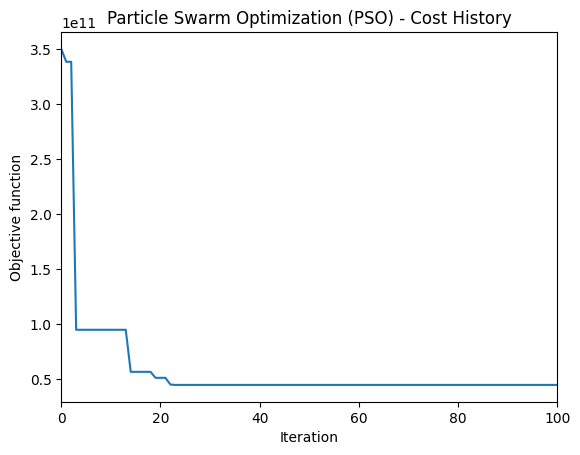

In [92]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

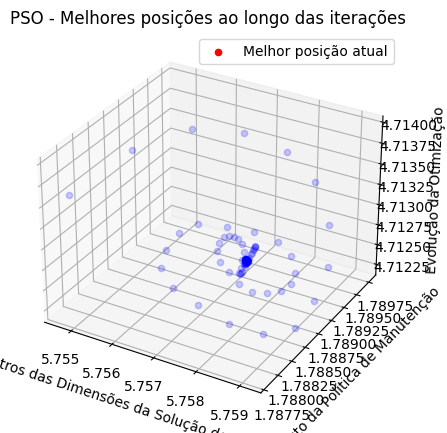

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 96213229994.34872


In [93]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Parâmetros das Dimensões da Solução de Otimização')
ax.set_ylabel('Custo da Política de Manutenção')
ax.set_zlabel('Evolução da Otimização')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])